In [1]:
filename = "KILN20190808_103655_V06"

# pixel coordinates (in the 300 km : 600 pixels scale):
px_c, py_c, pr_c =  565, 200, 55

In [2]:
from testing import *

# Assume we are working with Purple Martins
rcs = get_rcs(54)

name = "KILN20190808_103655_V06"
radar = read_s3(name)

sweep_number = 0

# Get the center and the radius of the bbox in pixel coordinates:
px_c, py_c, pr_c =  565, 200, 55

# Set the threshold above which we will consider reflectivity to be too # high (in linear scale):
threshold = 68402
        
# Convert the pixel coordinates to cartesian values:
detection_coordinates = image2xy(px_c, py_c, pr_c)

number_of_birds_polar, _, overthresh_count, volume_range = calc_number_of_birds(radar, sweep_number, detection_coordinates, rcs, threshold, method="polar")
print(number_of_birds_polar)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

22181.561199147567


In [3]:
number_of_birds_polar

22181.561199147567

In [4]:
# Helper function
def image2xy(x, y, r=0, dim=600, rmax=150000):
    '''
    Convert from image coordinates to (x,y) coordinates offset from radar
    '''
    
    x0 = y0 = dim/2.0 # origin
    x =  (x - x0)*2*rmax/dim
    y = -(y - y0)*2*rmax/dim
    r = r*2*rmax/dim
    
    return x, y, r

/Users/sheldon/darkecology/pywsrlib/wsrlib/wsrlib.py:507: RuntimeWarning: invalid value encountered in arccos
  thet = np.arccos((r_e + h) * np.sin(s/r_e) / r)


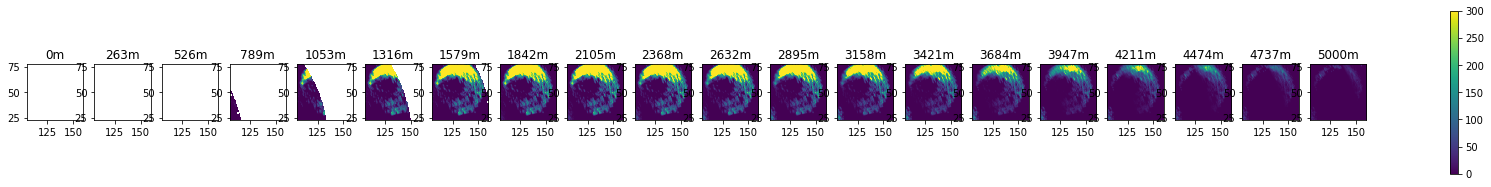

Grid spacing in km: dx=0.56, dy=0.56, dz=0.26
Approx. number of birds: 42176.4


In [5]:
# get roost coordinates in meters from radar
x0, y0, r = image2xy(px_c, py_c, pr_c)

# Get radar data on standardized polar grid
#  --- all sweeps have same range, az values
data, fields, elev, rng, az = radar2mat(radar, 
                                        coords='polar', 
                                        elevs=[0.5, 1.5, 2.5, 3.5, 4.5]);

# Convert to reflectivity on linear scale and set nans to zero
refl, _ = z_to_refl(idb(data[0]))
refl[np.isnan(refl)] = 0.

# The interpolating function
F = radarVolumeInterpolant(refl, elev, rng, az, method='linear', elev_buffer=0.5)

# Define grid
n_height_levels = 20
grid = Grid([
    (x0-r, x0+r, 100),          # arguments to np.linspace for x dimension
    (y0-r, y0+r, 100),          # y dimension 
    (0, 5000,  n_height_levels) # z dimension   
])

# Get radar coordinates of grid points
x, y, z = grid.points()
elev, rng, az = xyz2radar(x, y, z)

# Do interpolation
grid_val = F((elev, rng, az))

# Set above threshold values to zero
threshold = 68402
grid_val[grid_val > threshold] = 0

# Show results
x, y, height = grid.coords()
fig, ax = plt.subplots(ncols=n_height_levels, figsize=(1.5*n_height_levels,3))
vmin, vmax = 0, 300
for i in range(n_height_levels):
    im = ax[i].imshow(grid_val[:,:,i], 
                      extent = (x[0]/1000, x[-1]/1000, y[0]/1000, y[-1]/1000),
                      origin='lower', vmin=vmin, vmax=vmax)
    ax[i].set_title(f"{height[i]:.0f}m")
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

# Get grid spacing for volume computations
coords = grid.coords()
dx, dy, dz = np.array([np.diff(c).mean() for c in coords])/1000 # convert from meters to kilometers

# Compute total reflectivity and convert to number of birds
total_reflectivity = np.nansum(grid_val * dx * dy * dz)
rcs = get_rcs(54)
count = total_reflectivity / rcs
print(f"Grid spacing in km: dx={dx:.2f}, dy={dy:.2f}, dz={dz:.2f}")
print(f"Approx. number of birds: {count:.1f}")

In [6]:


# Work in progress...

def get_polar_grid_volume(theta, phi, r, dtheta, dphi, dr):
    # r and dr are in meters
    return r**2 * np.sin(theta) * dr * dtheta* dphi / 1e9 # convert from m^3 to km^3